In [130]:
import pandas as pd
import numpy as np

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn import metrics, model_selection
from sklearn.metrics import classification_report,roc_auc_score,accuracy_score,confusion_matrix
from sklearn.metrics import roc_curve,f1_score,precision_recall_fscore_support

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

In [131]:
# Loaded in the data
data = pd.read_csv('online_shoppers_intention.csv')
data.head(3)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False


In [132]:
# drop page values
data = data.drop('PageValues', axis = 1)

In [133]:
# encode
# we have 10 months, missing Jan, Apr 
# encode into quarters 
def division_func_month(div) :
    if div == 'Feb':
        return 1
    elif div == 'Mar':
        return 1
    elif div == 'May':
        return 2
    elif div == 'June':
        return 2
    elif div == 'Jul':
        return 3
    elif div == 'Aug':
        return 3
    elif div == 'Sep':
        return 3
    elif div == 'Oct':
        return 4
    elif div == 'Nov':
        return 4
    elif div == 'Dec':
        return 4
    else:
        return 0
    
# from object to integers
data['quarter'] = data['Month']
# apply function
data['quarter'] = data['quarter'].apply(division_func_month)

# encoding for revenue and weekend
def div_fun_visType(div) :
    if div == 'Returning_Visitor':
        return 1
    if div == 'New_Visitor':
        return 2
    else:
        return 0
    
# from boolean to integers
data['VisitorType_encode'] = data['VisitorType']
# apply function
data['VisitorType_encode'] = data['VisitorType_encode'].apply(div_fun_visType)

data1 = data.copy()
data1 = data1.drop(['VisitorType','Month'], axis = 1)

# revenue (Y) and weeked only have 2 unique values so there is no need to encode
data1 = pd.get_dummies(data1, columns=['VisitorType_encode','quarter','SpecialDay'])

In [134]:
data1.shape

(12330, 27)

### feature engineering (now with no page values)

In [135]:
# ratios for counts
data1['totalFracAdmin'] = data1['Administrative']/(data1['Administrative'] + data1['Informational'] + data1['ProductRelated'])
data1['totalFracInfo'] = data1['Informational']/(data1['Administrative'] + data1['Informational'] + data1['ProductRelated'])
data1['totalFracProd'] = data1['ProductRelated']/(data1['Administrative'] + data1['Informational'] + data1['ProductRelated'])

# drop original durations 
data1 = data1.drop(['Administrative','Informational','ProductRelated'], axis = 1)

# average combining
data1['BounceExitAvg'] = (data1['BounceRates'] + data1['ExitRates'])/2

# weighted-average feature joining
data1['BounceExitW1'] = data1['BounceRates'] * 0.6 + data1['ExitRates'] * 0.4
data1['BounceExitW2'] = data1['BounceRates'] * 0.7 + data1['ExitRates'] * 0.3
data1['BounceExitW3'] = data1['BounceRates'] * 0.4 + data1['ExitRates'] * 0.6
data1['BounceExitW4'] = data1['BounceRates'] * 0.3 + data1['ExitRates'] * 0.7

In [136]:
data1 = data1.fillna(0) # fill N/A with 0 
data1 = data1.replace(np.inf, 0) # replace inf wit 0
data1 = data1.replace(-0, 0) # for some reason we also get -0 just fix it to 0 

In [137]:
print('Original number of features: ', len(data.columns))
print('Total number of features added (after encoding, engineering): ', len(data1.columns) - len(data.columns))

Original number of features:  19
Total number of features added (after encoding, engineering):  13


### Standerdize

In [138]:
# make a copy
standardize = data1.copy()  
# select continous features (exclude Special Day)
standardize = standardize.select_dtypes(include='float64')

In [139]:
# use MinMaxScaler function 
scaler = MinMaxScaler()

# min-max standerdize all continous columns
standardize[standardize.columns] = scaler.fit_transform(standardize[standardize.columns]) # fit the scaler to the model 
standardize_done = standardize.add_suffix('_Scaled') # add suffix (new features)

# add new standerdized features to data1
data1 = pd.concat([data1, standardize_done], axis = 1 )

#use .describe() to prove standardization worked
standardize_done.describe()

,Administrative_Duration_Scaled,Informational_Duration_Scaled,ProductRelated_Duration_Scaled,BounceRates_Scaled,ExitRates_Scaled,totalFracAdmin_Scaled,totalFracInfo_Scaled,totalFracProd_Scaled,BounceExitAvg_Scaled,BounceExitW1_Scaled,BounceExitW2_Scaled,BounceExitW3_Scaled,BounceExitW4_Scaled
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.00000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,0.023779,0.013522,0.018676,0.110957,0.215364,0.079955,0.01446,0.905098,0.163160,0.152720,0.142279,0.173601,0.184042
std,0.052013,0.055209,0.029913,0.242442,0.242983,0.126751,0.05037,0.141883,0.237375,0.237535,0.238127,0.237646,0.238347
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.002878,0.000000,0.071429,0.000000,0.00000,0.860465,0.039532,0.033333,0.025805,0.046154,0.052593
50%,0.002207,0.000000,0.009362,0.015562,0.125782,0.021661,0.00000,0.963359,0.079255,0.066667,0.056848,0.088884,0.100000
75%,0.027438,0.000000,0.022887,0.084063,0.250000,0.115385,0.00000,1.000000,0.162709,0.140852,0.129167,0.175638,0.189772
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [140]:
print('Number of features before standardization: ', len(data1.columns) - len(standardize_done.columns))
print('Number of features added: ', len(standardize_done.columns))

Number of features before standardization:  32
Number of features added:  13


In [143]:
# drop features not scaled (keep encoded)
data1 = data1[['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend',
       'Revenue', 'VisitorType_encode_0', 'VisitorType_encode_1',
       'VisitorType_encode_2', 'quarter_1', 'quarter_2', 'quarter_3',
       'quarter_4', 'SpecialDay_0.0', 'SpecialDay_0.2', 'SpecialDay_0.4',
       'SpecialDay_0.6', 'SpecialDay_0.8', 'SpecialDay_1.0', 'totalFracAdmin',
       'totalFracInfo', 'totalFracProd', 'BounceExitAvg', 'BounceExitW1',
       'BounceExitW2', 'BounceExitW3', 'BounceExitW4',
       'Administrative_Duration_Scaled', 'Informational_Duration_Scaled',
       'ProductRelated_Duration_Scaled', 'BounceRates_Scaled',
       'ExitRates_Scaled', 'totalFracAdmin_Scaled', 'totalFracInfo_Scaled',
       'totalFracProd_Scaled', 'BounceExitAvg_Scaled', 'BounceExitW1_Scaled',
       'BounceExitW2_Scaled', 'BounceExitW3_Scaled', 'BounceExitW4_Scaled']]

### Normalization

In [144]:
normalization_df = standardize_done.copy()

In [145]:
# find skewed features 
normalization_needed = [] # empty list for cols that need normalizing 
normalization_df_cols = normalization_df.columns
for col in normalization_df_cols:
    if normalization_df[col].skew() > 0.5:
        print('Right skew: ',col,normalization_df[col].skew())
        normalization_needed.append(col)
    elif normalization_df[col].skew() < -0.5:
        print('Left skew: ',col,normalization_df[col].skew())
        normalization_needed.append(col)
    else:
        ""

Right skew:  Administrative_Duration_Scaled 5.6157190187741906
Right skew:  Informational_Duration_Scaled 7.5791847157342165
Right skew:  ProductRelated_Duration_Scaled 7.2632276825613165
Right skew:  BounceRates_Scaled 2.9478552666955338
Right skew:  ExitRates_Scaled 2.1487889999009795
Right skew:  totalFracAdmin_Scaled 2.6021648114344162
Right skew:  totalFracInfo_Scaled 8.71792989818395
Left skew:  totalFracProd_Scaled -2.4188748873082173
Right skew:  BounceExitAvg_Scaled 2.658645853438436
Right skew:  BounceExitW1_Scaled 2.7432714016393325
Right skew:  BounceExitW2_Scaled 2.8163076932534996
Right skew:  BounceExitW3_Scaled 2.564778543858945
Right skew:  BounceExitW4_Scaled 2.4642333180311855


In [146]:
print(len(normalization_needed),' features need normalizing')

13  features need normalizing


In [147]:
from scipy import stats
# innitial yeo-johnson normalization
for col in normalization_needed:
    normalization_df[col] = stats.yeojohnson(normalization_df[col])[0]

# square-root transformation for positively/rightly skewed features that still have a skew > 0.5 
for col in normalization_df_cols:
    if normalization_df[col].skew() > 0.5:
        normalization_df[col] = np.sqrt(normalization_df[col])

In [148]:
not_normalized = []
# if still not normal display 
for col in normalization_df_cols:
    if normalization_df[col].skew() > 0.5:
        print('Right skew: ',col,normalization_df[col].skew())
        not_normalized.append(col)
    elif normalization_df[col].skew() < -0.5:
        print('Left skew: ',col,normalization_df[col].skew())
        not_normalized.append(col)
    else:
         print('Normalized', col,normalization_df[col].skew())

Normalized Administrative_Duration_Scaled 0.3295801795635637
Right skew:  Informational_Duration_Scaled 1.7326012884342452
Normalized ProductRelated_Duration_Scaled -0.23543933031636485
Normalized BounceRates_Scaled 0.3262257513950875
Normalized ExitRates_Scaled 0.3379450817642422
Normalized totalFracAdmin_Scaled 0.15463883173278434
Right skew:  totalFracInfo_Scaled 1.4670525404458559
Left skew:  totalFracProd_Scaled -0.581060550431929
Normalized BounceExitAvg_Scaled -0.14021732571738893
Normalized BounceExitW1_Scaled -0.06154026184381935
Normalized BounceExitW2_Scaled 0.036799663481299594
Normalized BounceExitW3_Scaled 0.4776758903657082
Normalized BounceExitW4_Scaled 0.43335849977275076


In [149]:
for col in normalization_needed: # All needed normalization 
    normalization_done = normalization_df.add_suffix('_Norm') # add suffix to distinguish 

In [150]:
# concat normalized features with scaled and original
data1 = pd.concat([data1,normalization_done], axis = 1)

### Feature selection with Embeded method - Random forest
- with threshold of 0.028 it selected 7 featueres

In [152]:
X = data1.drop('Revenue', axis = 1)
y = data1.Revenue
feature_name = X.columns.tolist()

In [157]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
# n_estimators = The number of trees in the forest (10-100)
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=50, random_state = 123), threshold=0.028)
embeded_rf_selector.fit(X, y)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=50, n_jobs=None,
                                                 oob_score=False,


In [158]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

7 selected features


- here we see what features are the most important according to feature selection

In [159]:
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name,'Random Forest':embeded_rf_support})
# count the selected times for each feature
#feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 65
feature_selection_df = feature_selection_df.sort_values(['Random Forest'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(7)

,Feature,Random Forest
1,Administrative_Duration_Scaled,True
2,BounceExitW3,True
3,ProductRelated_Duration_Scaled_Norm,True
4,Administrative_Duration_Scaled_Norm,True
5,ExitRates_Scaled,True
6,ProductRelated_Duration_Scaled,True
7,BounceExitW4_Scaled_Norm,True


### feature importance for Random Forest

In [160]:
# Split dataset into training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80% training and 20% test

In [161]:
## Import the random forest model.
from sklearn.ensemble import RandomForestClassifier 
## This line instantiates the model. 
rf = RandomForestClassifier() 
## Fit the model on your training data.
rf.fit(X_train, y_train) 

feature_importances = pd.DataFrame(rf.feature_importances_,index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [162]:
feature_importances.head(20) # select one from each variation 

,importance
ProductRelated_Duration_Scaled_Norm,0.061632
ProductRelated_Duration_Scaled,0.061501
ExitRates_Scaled,0.032840
Administrative_Duration_Scaled_Norm,0.030358
Administrative_Duration_Scaled,0.030308
ExitRates_Scaled_Norm,0.030031
BounceExitW4,0.029946
TrafficType,0.027809
totalFracProd_Scaled,0.027726
BounceExitAvg,0.027129


### top 5 features (including only 1 feature version)
- We see that product related duration feature is still very important which makes sense. Depending on how much time they spend looking at products more likely they will buy (of course there are other factors to consider here)
- Exit rates also an important determinent to the revenue. Lower the exit rate more time users will spend on the page.
- Administrative duration also important. We believe this if the user is actually interested in making a purchase he will take time to create or optimize their account.
- Traffic type seems important which we did not see in our main feature importance. We assume this is encompasses the users behavior through the session. 
- An our engineered feature totalFracProd_Scaled is in 5th place (product page views/total views between all pages). Which as go to say that it is important to easily and efficiently direct customers to the product page.

In [164]:
feature_importances.iloc[[0,2,3,7,8],:]

,importance
ProductRelated_Duration_Scaled_Norm,0.061632
ExitRates_Scaled,0.032840
Administrative_Duration_Scaled_Norm,0.030358
TrafficType,0.027809
totalFracProd_Scaled,0.027726


## Top 2 features closer look

In [165]:
import matplotlib.pyplot as plt 
import seaborn as sns

# subsetting dataframe
rev_true = data1[data1['Revenue']==True]
rev_false = data1[data1['Revenue']==False]

print(rev_true.shape)
print(rev_false.shape)

(1908, 53)
(10422, 53)


### ProductRelated_Duration_Scaled_Norm
- For revenue true we see low distribution when duration is lower (0-0.06). Makes sense if they spend less time on the page less likely users will purchase. However, those who do must be familar with the website and know what they want. The distribution then increases exponentially until 0.10 - 0.14 and then spikes again for 0.15. 0.10 - 0.15 duration could be considered the hisghes chance the user will purchase comparing to revenue false. So it would be wise to devise the website in such a way users will spend that amount of time on the page (specific call to action, discounts etc.)
- For revenue false there are many 0 values which signify the user did not make it to the page = no revenue. It would be wise to get some answers as to why that happened. 

Text(0, 0.5, 'Density')

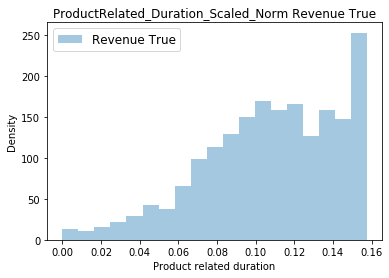

In [168]:
feat1_1 = rev_true.ProductRelated_Duration_Scaled_Norm
sns.distplot(feat1_1,  kde=False, label='Revenue True')

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('ProductRelated_Duration_Scaled_Norm Revenue True')
plt.xlabel('Product related duration')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

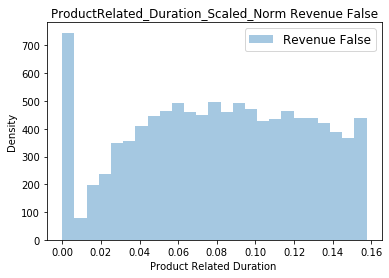

In [171]:
feat1_0 = rev_false.ProductRelated_Duration_Scaled_Norm
sns.distplot(feat1_0,  kde=False, label='Revenue False')

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('ProductRelated_Duration_Scaled_Norm Revenue False')
plt.xlabel('Product Related Duration ')
plt.ylabel('Density')

### ExitRates_Scaled
- The closer the the exit rate is to zero and less outliers it has to the right, the more likely user will make a purchase. 
- It would be interesting see what are the factors on the website that customers do not like that prompts them to exit

Text(0, 0.5, 'Density')

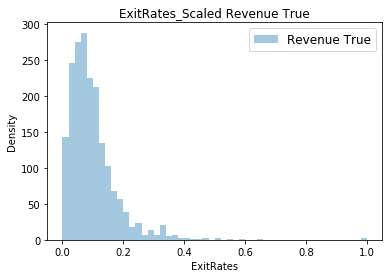

In [172]:
feat1_1 = rev_true.ExitRates_Scaled
sns.distplot(feat1_1,  kde=False, label='Revenue True')

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('ExitRates_Scaled Revenue True')
plt.xlabel('ExitRates')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

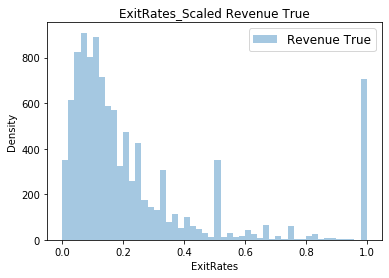

In [173]:
feat1_0 = rev_false.ExitRates_Scaled
sns.distplot(feat1_0,  kde=False, label='Revenue True')

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('ExitRates_Scaled Revenue True')
plt.xlabel('ExitRates')
plt.ylabel('Density')

## Modeling

- Using our best model, same parametes, and now different features without page values

In [174]:
X = data1[['ProductRelated_Duration_Scaled_Norm','ExitRates_Scaled','Administrative_Duration_Scaled_Norm',
          'TrafficType','totalFracProd_Scaled']]
y = data1.Revenue

In [175]:
# lists for f1-score and AUC
f1_score_lst = []
auc_lst = []
f1_scores = []
roc_scores = []

#loop to calculate f1 and auc scores and present averages after 10 runs
for count in range (1,10):

    # create training and testing vars
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, shuffle = True)
    
    # this is the formula after you split the dataset
    sm = SMOTE(random_state=123, sampling_strategy = 'minority')
    x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

    # Train model
    clf = RandomForestClassifier(random_state = 123)
    clf.fit(x_train_res, y_train_res)

    # Predict on training set
    pred_y = clf.predict(X_test)

    #10-fold cross validation
    kfold = model_selection.KFold(n_splits=10, random_state=123, shuffle = True)
    scoring = 'accuracy'
    results = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring=scoring)
    
    # average is the bias, and std dev is variance
    f1_scores = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring='f1')
    roc_scores = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring='roc_auc')

    #calculate f1-score and AUC
    clf_roc_auc = roc_auc_score(y_test, pred_y)
    
    #calculate average f1-score and AUC
    f1_score_lst.append(precision_recall_fscore_support(y_test, pred_y, average='weighted')[2])
    auc_lst.append(clf_roc_auc)
    
    
print('F1 {:.4f}; AUC {:.4f} '.format(np.mean(f1_score_lst),np.mean(auc_lst)))

print('average f1 score (bias)', f1_scores.mean())
print('average f1 score (variance)', f1_scores.std())
print('average AUC score (bias)', roc_scores.mean())
print('average AUC score (variance)', roc_scores.std())

# Is our model still predicting just one class?
print('Model is predicting ',np.unique( pred_y ),'class' )

print('Accuracy of classifier on test set: {:.3f}'.format(clf.score(X_test, y_test)))

print("10-fold cross validation average accuracy of clf_4: %.3f" % (results.mean()))

confusion_matrix_y = confusion_matrix(y_test, pred_y)
print('Confusion Matrix for Classfier:')
print(confusion_matrix_y)

print('Classification Report for Classfier:')
print(classification_report(y_test, pred_y))

F1 0.7396; AUC 0.5999 
average f1 score (bias) 0.839114262714695
average f1 score (variance) 0.009009402851553484
average AUC score (bias) 0.912703938338528
average AUC score (variance) 0.00909292681439649
Model is predicting  [False  True] class
Accuracy of classifier on test set: 0.715
10-fold cross validation average accuracy of clf_4: 0.831
Confusion Matrix for Classfier:
[[1591  478]
 [ 226  171]]
Classification Report for Classfier:
              precision    recall  f1-score   support

       False       0.88      0.77      0.82      2069
        True       0.26      0.43      0.33       397

    accuracy                           0.71      2466
   macro avg       0.57      0.60      0.57      2466
weighted avg       0.78      0.71      0.74      2466

